In [226]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import sph_harm
from scipy.integrate import quad, dblquad

import numpy as np
import trimesh as tri
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
import os

sys.path.insert(0,"../")
import pyssht
sphere = tri.creation.uv_sphere(count=[16, 16])

## Spherical decomposition and reconstruction tools

In [267]:
import numpy as np
from scipy.special import sph_harm
import scipy.integrate as integrate

class SphHarmBasis():
    def __init__(self, n_coeffs=16):
        self._n_coeffs = n_coeffs
        self.basis = self.sph_harm_basis()
    
    def get_sph_harm_function(self, l, m):
        """Compute real spherical harmonic basis function"""
        def basis_function(theta, phi):
            Y = sph_harm(abs(m), l, phi, theta)
            
            if m < 0:
                Y = np.sqrt(2) * (-1)**m * Y.imag
            elif m > 0:
                Y = np.sqrt(2) * (-1)**m * Y.real
                
            return Y.real
        
        return basis_function

    def sph_harm_basis(self):
        """Get a specified number of basis functions"""
        basis_functions = []

        dimension = 0
        l, m = 0, 0

        while dimension < self._n_coeffs:
            while m <= l:
                basis_functions.append(self.get_sph_harm_function(l, m))
                m += 1
                dimension += 1
            
            l += 1
            m = -l  
        
        return basis_functions

    def sph_harm_coeff(self, Y, f):
        """Compute spherical harmonic coefficients"""
        def integrand(phi, theta):
            return f(theta, phi) * Y(theta, phi) * np.sin(theta)
        options={'limit':50}
        res = integrate.nquad(integrand, [[0., 2*np.pi], [0., np.pi]], opts=[options,options] )[0]
        return res

    def sph_harm_transform(self, f, basis=None):
        """Get spherical harmonic coefficients for a function in a basis"""
        if basis is None:
            basis = self.basis
        
        coeffs = []

        for Y in basis:
            coeffs.append(self.sph_harm_coeff(Y, f))

        return coeffs

    def sph_harm_reconstruct(self, coeffs, basis=None):
        """Reconstruct a function from basis and corresponding coefficients"""
        if basis is None:
            basis = self.basis
        
        return lambda theta, phi : np.dot(coeffs, [f(theta, phi) for f in basis])

In [268]:
def my_sphere_function(theta, phi):
    return np.sin(theta+phi)

my_basis = SphHarmBasis(n_coeffs=100)

# encode your function in the desired basis and record the coefficients
my_coeffs = my_basis.sph_harm_transform(my_sphere_function)

# reconstruct your function at a point
point = (np.pi, np.pi/8)
my_basis.sph_harm_reconstruct(my_coeffs)(*point), my_sphere_function(*point)

(-5.063136820628938e-17, -0.38268343236508967)

### Example

WARNING - 2022-06-21 16:13:56,994 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING - 2022-06-21 16:13:57,015 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.07604822166366358


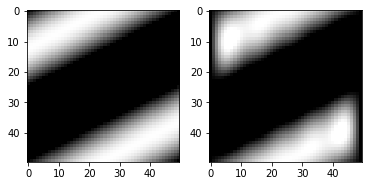

In [258]:
my_reconstr_function = my_basis.sph_harm_reconstruct(my_coeffs)

pts_phi = np.linspace(0, 2*np.pi)
pts_theta = np.linspace(0, np.pi)
pts_2d = np.reshape(np.stack(np.meshgrid(pts_theta,pts_phi), axis=-1), (-1, 2))

actual = []
approx = []

pts_total = 0

for n, pt in enumerate(pts_2d):
    f_actual = my_sphere_function(*pt)
    f_approx = my_reconstr_function(*pt)
    
    actual.append(f_actual)
    approx.append(f_approx)

    pts_total += abs(f_approx - f_actual)
    
print(pts_total / len(pts_2d))

plt.subplot(121)
plt.imshow(np.reshape(np.repeat(actual, 3), (50, 50, 3)))

plt.subplot(122)
plt.imshow(np.reshape(np.repeat(approx, 3), (50, 50, 3)))
plt.show()

### For shapes (test with the 2-sphere)

In [259]:
def my_sphere_function_theta(theta, phi):
    return theta

def my_sphere_function_phi(theta, phi):
    return phi

In [260]:
x, y ,z = np.array(sphere.vertices[:,0]), np.array(sphere.vertices[:,1]), np.array(sphere.vertices[:,2])
(r, theta, phi) = pyssht.cart_to_spherical(x, y, z)

In [261]:
f_actual_theta = my_sphere_function_theta(theta,phi)
f_actual_phi = my_sphere_function_phi(theta,phi)

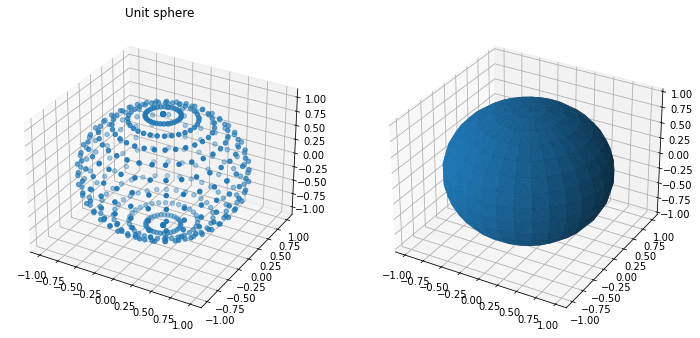

In [262]:
(x_coord, y_coord, z_coord) = pyssht.spherical_to_cart(r, f_actual_theta, f_actual_phi)
mesh = tri.convex.convex_hull(np.array([x_coord, y_coord, z_coord]).T)

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x_coord, y_coord, z_coord)
ax1.set_title("Unit sphere")

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_trisurf(mesh.vertices[:, 0], mesh.vertices[:,1], triangles=mesh.faces, Z=mesh.vertices[:,2])

plt.show()

In [263]:
my_basis = SphHarmBasis(n_coeffs=100)

my_coeffs_theta = my_basis.sph_harm_transform(my_sphere_function_theta)
my_coeffs_phi = my_basis.sph_harm_transform(my_sphere_function_phi)

my_reconstr_function_theta = my_basis.sph_harm_reconstruct(my_coeffs_theta)
my_reconstr_function_phi = my_basis.sph_harm_reconstruct(my_coeffs_phi)

In [264]:
f_recons_theta = my_reconstr_function_theta(theta,phi)
f_recons_phi = my_reconstr_function_phi(theta,phi)

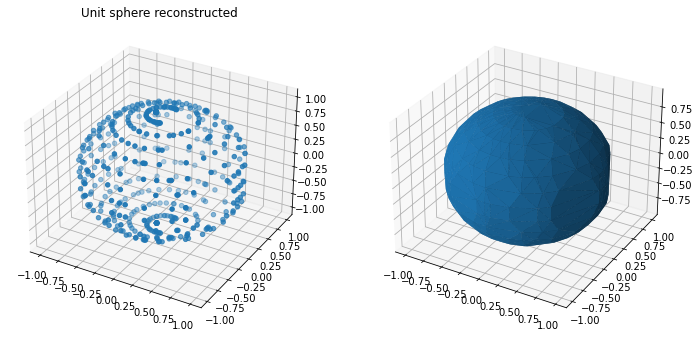

In [265]:
(x_coord_recons, y_coord_recons, z_coord_recons) = pyssht.spherical_to_cart(r, f_recons_theta, f_recons_phi)
mesh_recons = tri.convex.convex_hull(np.array([x_coord_recons, y_coord_recons, z_coord_recons]).T)

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x_coord_recons, y_coord_recons, z_coord_recons)
ax1.set_title("Unit sphere reconstructed")

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_trisurf(mesh_recons.vertices[:, 0], mesh_recons.vertices[:,1], triangles=mesh_recons.faces, Z=mesh_recons.vertices[:,2])
plt.show()

Imprecision on the borders of $[0, \pi] \times [0, 2 \pi]$ !!!

# Brownian motion on the basis